# AY 250 Final Project

### Sam Badman - 4/28/18

__Simulating Drag Force and Torque Using Ray Tracing__

In [82]:
%matplotlib inline
import numpy as np
import numpy.linalg as npl
from ipywidgets import interact
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D,art3d
from importlib import reload
import ray_tracer as rt
reload(rt)

Ny = 20
Nz = 20
# Center of ray plane should be > furtherst vertex of shape
rc=1.*max(npl.norm(rt.get_shape(),axis=1).flatten())
yp = 2.0*rc
zp = 2.0*rc

def update_plot(ray_ind=int((Ny+1)*(Nz+1)/2.),az=0,el=0) :    
    face_number,r_int,source = rt.compute_intersections(ray_ind = ray_ind, az = az,
                                                    el = el, yp = yp, zp = zp,
                                                    Ny = Ny, Nz = Nz, rc = rc 
                                                    )

    rp,rp_refl = rt.ray_coords(az=az,el=el,yp=yp,zp=zp,Ny=Ny,Nz=Nz,rc=rc)
    
    if face_number == '' : r_int = r_int[ray_ind,:]

    tripoint_arr = rt.get_shape()

    f = plt.figure(figsize=(14,14))
    ax=plt.subplot(projection='3d')
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_zlim([-5,5])
    face_count = 0
    for tripoints in tripoint_arr :
        tri = art3d.Poly3DCollection([tripoints],alpha=0.5)
        tri.set_edgecolor('k')
        if face_number != '' :
            if face_count == face_number : tri.set_facecolor('red')
            else : tri.set_facecolor('white')
        else : tri.set_facecolor('white')
        ax.add_collection3d(tri)
        face_count += 1
    ax.scatter(rp[:,0],rp[:,1],rp[:,2])
    ax.plot([rp[ray_ind,0],r_int[0]],[rp[ray_ind,1],r_int[1]]
           ,[rp[ray_ind,2],r_int[2]],color='black',linewidth=3)
    ax.scatter(r_int[0],r_int[1],r_int[2],marker='.',s=400,color='red')
    if face_number == '' : ax.text3D(-2,2,2,'No Intersection',fontsize=30)
    #ax.view_init(0,-90)
    plt.show()
    
interact(update_plot,ray_ind = (0,(Ny+1)*(Nz+1),1),az=(0,360,10),el=(-90,90,10))

interactive(children=(IntSlider(value=220, description='ray_ind', max=441), IntSlider(value=0, description='az', max=360, step=10), IntSlider(value=0, description='el', max=90, min=-90, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.update_plot>

In [85]:
az = 0
el = -10
Ny = 20
Nz = 20
# Center of ray plane should be > furtherst vertex of shape
pts = np.array(rt.get_shape())
rc= np.max(npl.norm(pts,axis=1).flatten())
yp = 2.0*rc
zp = 2.0*rc
force,torque,hits,sources,faces=rt.compute_drag(az=az,el=el,Ny=Ny,Nz=Nz,yp=yp,zp=zp,rc=rc)
#hits,norm =rt.compute_drag(az=az,el=el,Ny=Ny,Nz=Nz,yp=yp,zp=zp,rc=rc)
torque[abs(torque) < 1e-12] = 0.0
print("Force Vector :", force)
print("Torque Vector :", torque)

Force Vector : [-32.49865585   0.           5.73038986]
Torque Vector : [  0.         -17.90977387   0.        ]


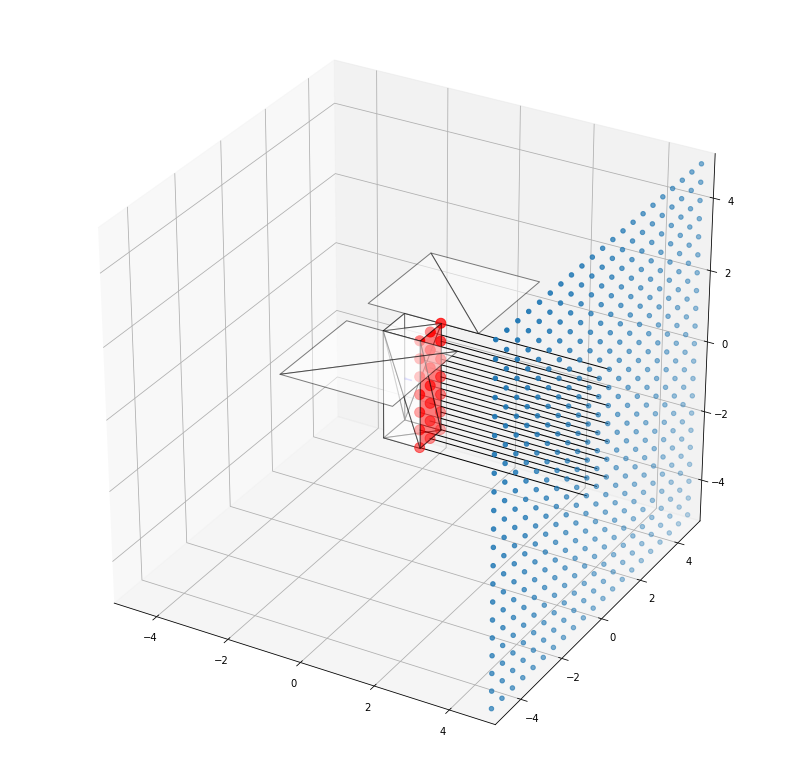

In [26]:
#Visualize hits on body
tripoint_arr = rt.get_shape()
rp,rp_refl = rt.ray_coords(az=az,el=el,yp=yp,zp=zp,Ny=Ny,Nz=Nz,rc=rc)
f = plt.figure(figsize=(14,14))
ax=plt.subplot(projection='3d')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_zlim([-5,5])
face_count = 0
for tripoints in tripoint_arr :
    tri = art3d.Poly3DCollection([tripoints],alpha=0.5)
    tri.set_edgecolor('k')
    if face_count in faces : tri.set_facecolor('red')
    else : tri.set_facecolor('white')
    ax.add_collection3d(tri)
    face_count += 1
ax.scatter(rp[:,0],rp[:,1],rp[:,2])
jj=0
for ii in range(len(hits)) :
    ax.plot([sources[ii,0],hits[ii,0]],[sources[ii,1],hits[ii,1]]
           ,[sources[ii,2],hits[ii,2]],color='black',linewidth=1)
ax.scatter(hits[:,0],hits[:,1],hits[:,2],marker='.',s=400,color='red')
ax.quiver(0,0,0,force[0]/100.,force[1]/100.,force[2]/100.,color='blue')
ax.quiver(0,0,0,torque[0]/100.,torque[1]/100.,torque[2]/100.,color='green')
#ax.view_init(90,0)
plt.show()

In [30]:
#reload(rt)
#dt = rt.tabulate_drag(20,20,yp,zp,rc)
dt = pickle.load(open("dt_tabulated.pkl","rb"))

Calculating drag force and torque for :
Azimuth :360.0 deg, Elevation :90.0 degg

In [31]:
import pickle
pickle.dump(dt,open("dt_tabulated.pkl","wb"))

In [89]:
def update_plot(az=0,el=0) :    

    rp,rp_refl = rt.ray_coords(az=az,el=el,yp=yp,zp=zp,Ny=Ny,Nz=Nz,rc=rc)

    tripoint_arr = rt.get_shape()

    f = plt.figure(figsize=(14,14))
    ax=plt.subplot(projection='3d')
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_zlim([-5,5])
    face_count = 0
    for tripoints in tripoint_arr :
        tri = art3d.Poly3DCollection([tripoints],alpha=0.5)
        tri.set_edgecolor('k')
        tri.set_facecolor('white')
        ax.add_collection3d(tri)
        face_count += 1
    ii = int(az/(360/36))
    jj = int((el+90)/(180/18))
    ft = dt[ii][jj]
    force,torque = ft[0],ft[1]
    ax.quiver(0,0,0,force[0]/10.,force[1]/10.,force[2]/10.,color='blue')
    ax.quiver(0,0,0,torque[0]/10.,torque[1]/10.,torque[2]/10.,color='green')
    ax.scatter(rp[:,0],rp[:,1],rp[:,2])
    #ax.view_init(0,-90)
    plt.show()
    
interact(update_plot,az=(0,360,10),el=(-90,90,10))

interactive(children=(IntSlider(value=0, description='az', max=360, step=10), IntSlider(value=0, description='el', max=90, min=-90, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.update_plot>